In [2]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 22, 4
import time

import seaborn as sns
from sklearn import metrics, ensemble, tree, linear_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

# import xgboost as xgb

from fancyimpute import SimpleFill, BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE


# Load data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_y = train_df.pop('SalePrice') # take out y value
test_id = test_df.pop('Id') # for writing submission file
# also remove id column from train as it will not be used
train_df.drop('Id', axis = 1, inplace=True)

In [3]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
print train_df.shape
print test_df.shape

(1460, 79)
(1459, 79)


In [5]:
# check number of nan in both train and test for each columns
def check_null(df):
    null_check = df.isnull().sum(axis=0)
    null = null_check[null_check!=0]
    null_df = df.isnull()
    return null, null_df
train_null, _ = check_null(train_df)
test_null, _ = check_null(test_df)
# print ">>>null value in train:\n", train_null
# print "\n>>>null value in test:\n", test_null

In [6]:
# train_null.plot.bar()

In [7]:
# test_null.plot.bar()

In [8]:
# get rid off columns with missing values more than 15%
drop_cols1 = [train_null.index[i] for i in range(train_null.shape[0]) if train_null.values[i] > train_df.shape[0]*0.15]
drop_cols2 = [test_null.index[i] for i in range(test_null.shape[0]) if test_null.values[i] > test_df.shape[0]*0.15]
drop_cols = list(set(drop_cols1+drop_cols2))
print drop_cols

['Fence', 'LotFrontage', 'MiscFeature', 'Alley', 'FireplaceQu', 'PoolQC']


In [9]:
# finish drop and start impute rest missing data
train_df.drop(drop_cols, axis = 1, inplace=True)
test_df.drop(drop_cols, axis = 1, inplace=True)

# after dropping selected columns, we want to impute which requires
# data to be numeric value, so we proceed to convert categorical data
# but this conversion erases nan, so here we record where the nan is
_, train_nulls = check_null(train_df)
_, test_nulls = check_null(test_df)

In [10]:
# convert object to categorical value first
# record what columns are categorical and numeric columns
obj_columns = train_df.select_dtypes(['object']).columns
num_columns = list(set(train_df.columns)-set(obj_columns))

# just in case test set has more categories than train, concatenate them first for conversion
train_df.loc[:, 'temp'] = 'train'
test_df.loc[:, 'temp'] = 'test'
combined_df = pd.concat([train_df, test_df])

for col in obj_columns:
    combined_df[col] = combined_df[col].astype('category')
# now convert train set
combined_df[obj_columns] = combined_df[obj_columns].apply(lambda x: x.cat.codes)

# now split back to train and test
train_df = combined_df[combined_df['temp']=='train'].drop(['temp'], axis=1)
test_df = combined_df[combined_df['temp']=='test'].drop(['temp'], axis=1)

In [11]:
# get the nan back
train_df[train_nulls] = np.nan
test_df[test_nulls] = np.nan

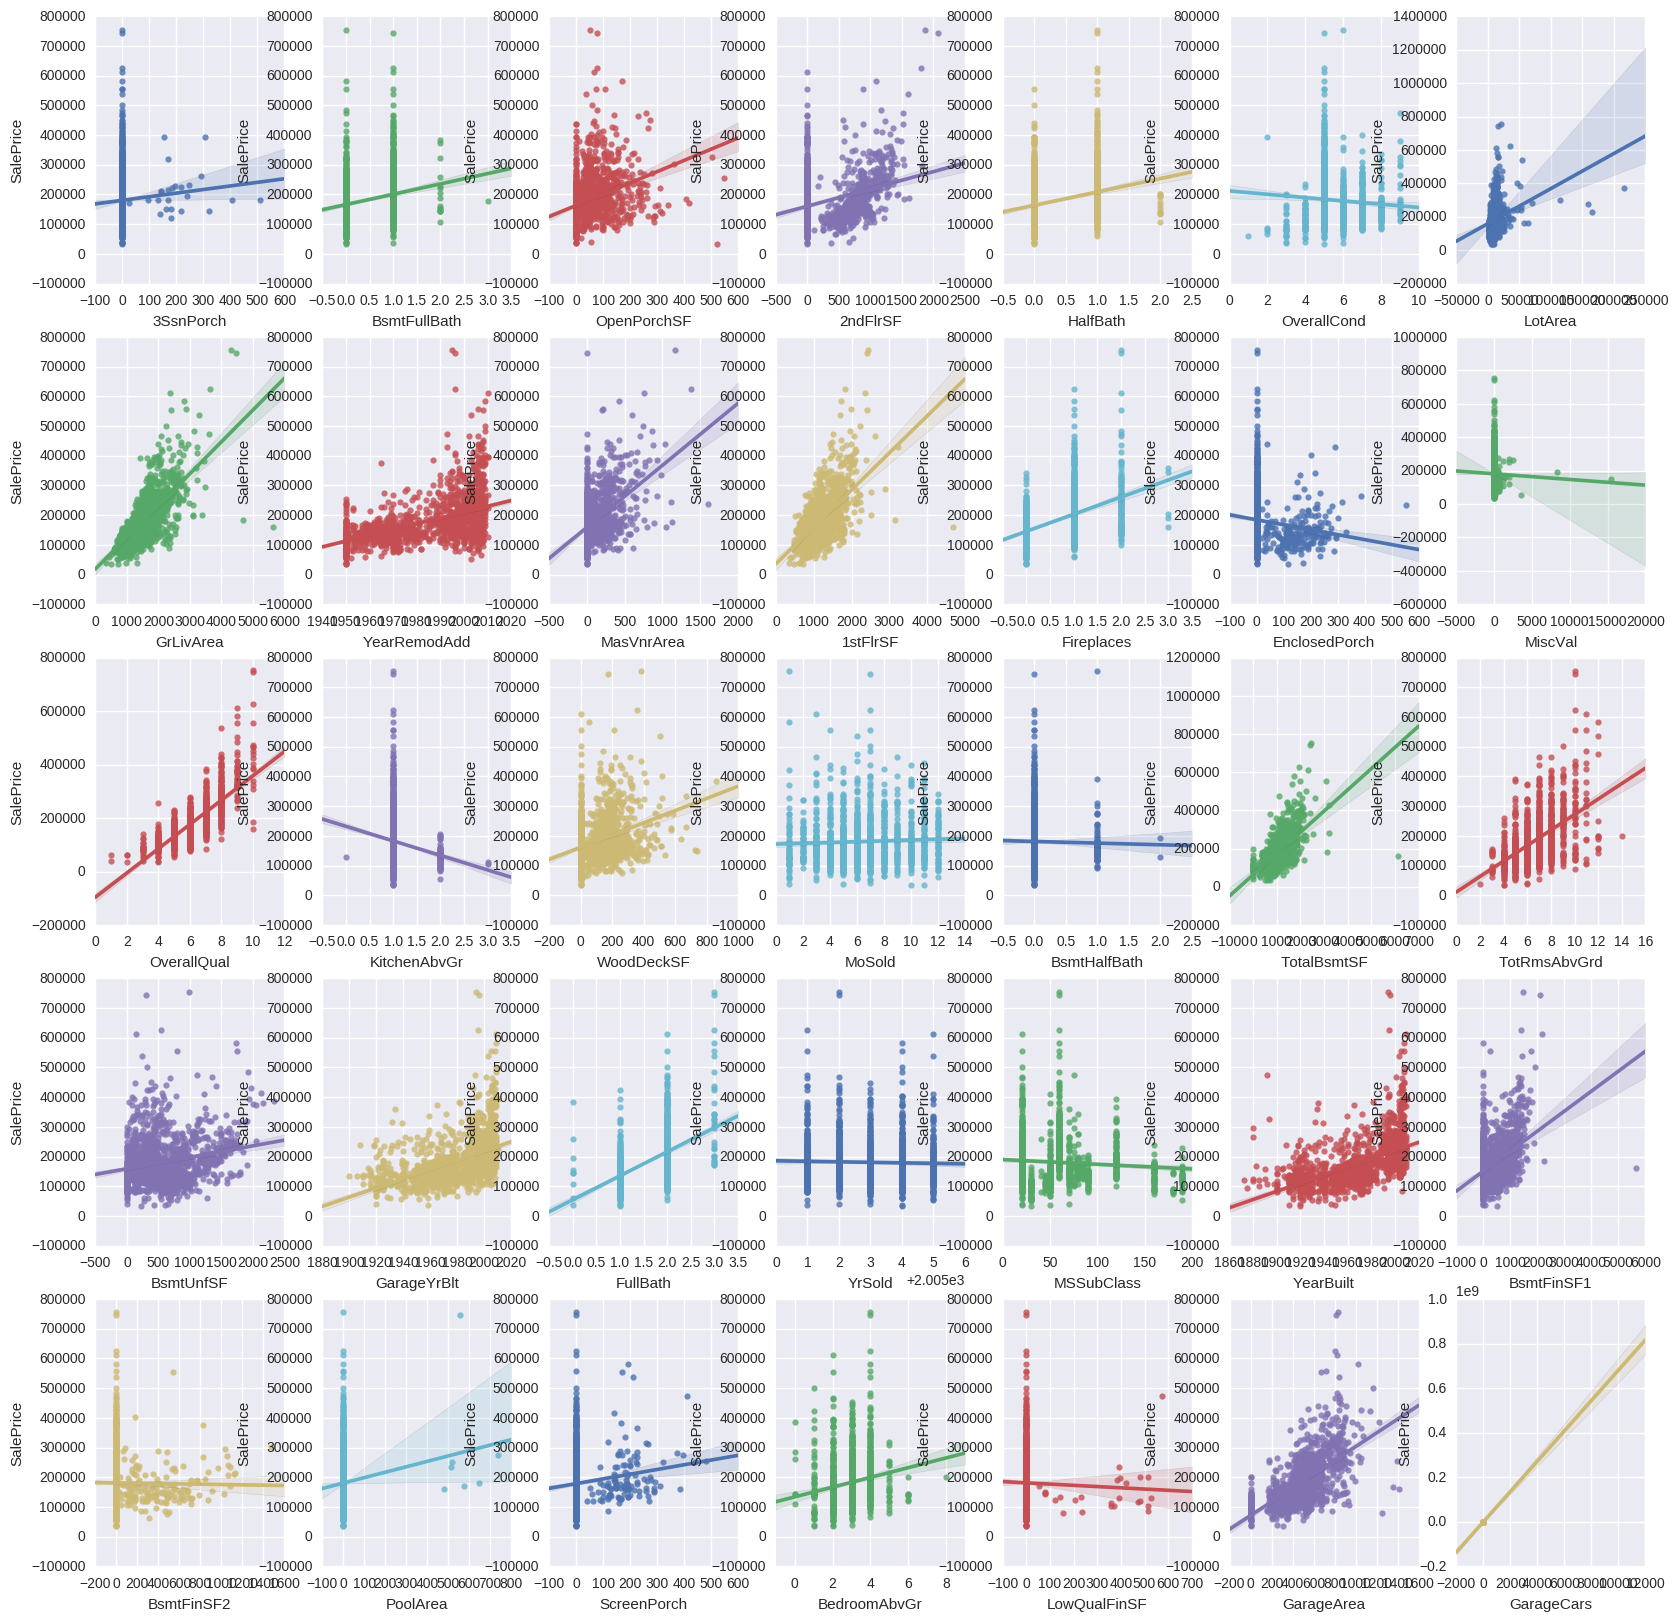

In [12]:
rcParams['figure.figsize'] = 20, 20
# take a look of each variable vs y
f, axes = plt.subplots(5,7)
n_iter = 0
for i in range(5):
    for j in range(7):
        sns.regplot(x=train_df[num_columns[n_iter]], y=train_y,ax=axes[i][j])
        n_iter += 1

In [13]:
# outliers
# drop outliers
outliers_id = np.array([524, 1299])
outliers_id = outliers_id - 1 # id starts with 1, index starts with 0
train_df.drop(outliers_id, inplace=True)
train_y.drop(outliers_id, inplace=True)

In [14]:
# impute missing data

# train_df = SimpleFill().complete(train_df)
# train_df = SoftImpute().complete(train_df)
# train_df = KNN(k=5).complete(train_df)
train_df[train_df.columns] = MICE().complete(train_df.values)

# test_df = SimpleFill().complete(test_df)
# test_df = SoftImpute().complete(test_df)
# test_df = KNN(k=5).complete(test_df)
test_df[test_df.columns] = MICE().complete(test_df.values)

train_df = pd.DataFrame(train_df, columns=train_df.columns)
test_df = pd.DataFrame(test_df, columns=test_df.columns)

[MICE] Completing matrix with shape (1458, 73)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.054
[MICE] Starting imputation round 3/110, elapsed time 0.064
[MICE] Starting imputation round 4/110, elapsed time 0.076
[MICE] Starting imputation round 5/110, elapsed time 0.085
[MICE] Starting imputation round 6/110, elapsed time 0.095
[MICE] Starting imputation round 7/110, elapsed time 0.105
[MICE] Starting imputation round 8/110, elapsed time 0.115
[MICE] Starting imputation round 9/110, elapsed time 0.125
[MICE] Starting imputation round 10/110, elapsed time 0.134
[MICE] Starting imputation round 11/110, elapsed time 0.144
[MICE] Starting imputation round 12/110, elapsed time 0.154
[MICE] Starting imputation round 13/110, elapsed time 0.164
[MICE] Starting imputation round 14/110, elapsed time 0.174
[MICE] Starting imputation round 15/110, elapsed time 0.183
[MICE] Starting imputation round 16/110, elapsed time 0.193
[M

[MICE] Starting imputation round 33/110, elapsed time 0.721
[MICE] Starting imputation round 34/110, elapsed time 0.743
[MICE] Starting imputation round 35/110, elapsed time 0.763
[MICE] Starting imputation round 36/110, elapsed time 0.784
[MICE] Starting imputation round 37/110, elapsed time 0.804
[MICE] Starting imputation round 38/110, elapsed time 0.824
[MICE] Starting imputation round 39/110, elapsed time 0.845
[MICE] Starting imputation round 40/110, elapsed time 0.865
[MICE] Starting imputation round 41/110, elapsed time 0.885
[MICE] Starting imputation round 42/110, elapsed time 0.908
[MICE] Starting imputation round 43/110, elapsed time 0.938
[MICE] Starting imputation round 44/110, elapsed time 0.961
[MICE] Starting imputation round 45/110, elapsed time 0.981
[MICE] Starting imputation round 46/110, elapsed time 1.001
[MICE] Starting imputation round 47/110, elapsed time 1.021
[MICE] Starting imputation round 48/110, elapsed time 1.043
[MICE] Starting imputation round 49/110,

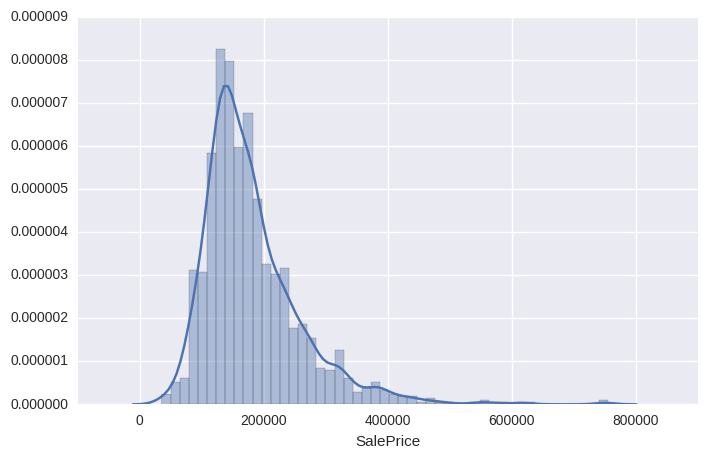

In [15]:
# Our SalesPrice is skewed right (check plot below) 
rcParams['figure.figsize'] = 8, 5
ax = sns.distplot(train_y)

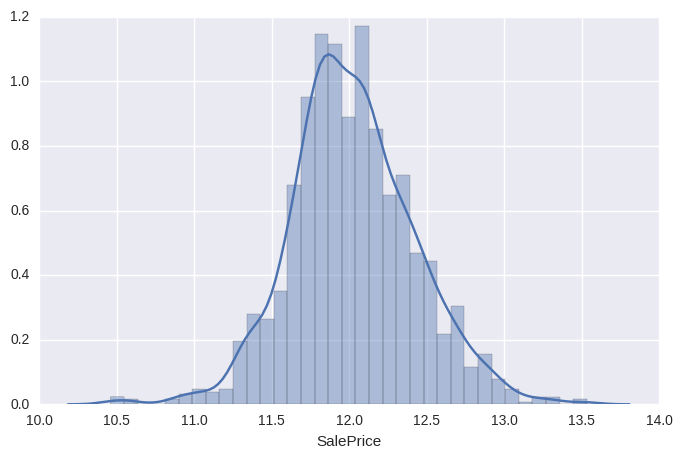

In [16]:
## we can log transform y value
rcParams['figure.figsize'] = 8, 5
ax = sns.distplot(np.log1p(train_y))
train_y = np.log1p(train_y)

number of numeric columns:  35


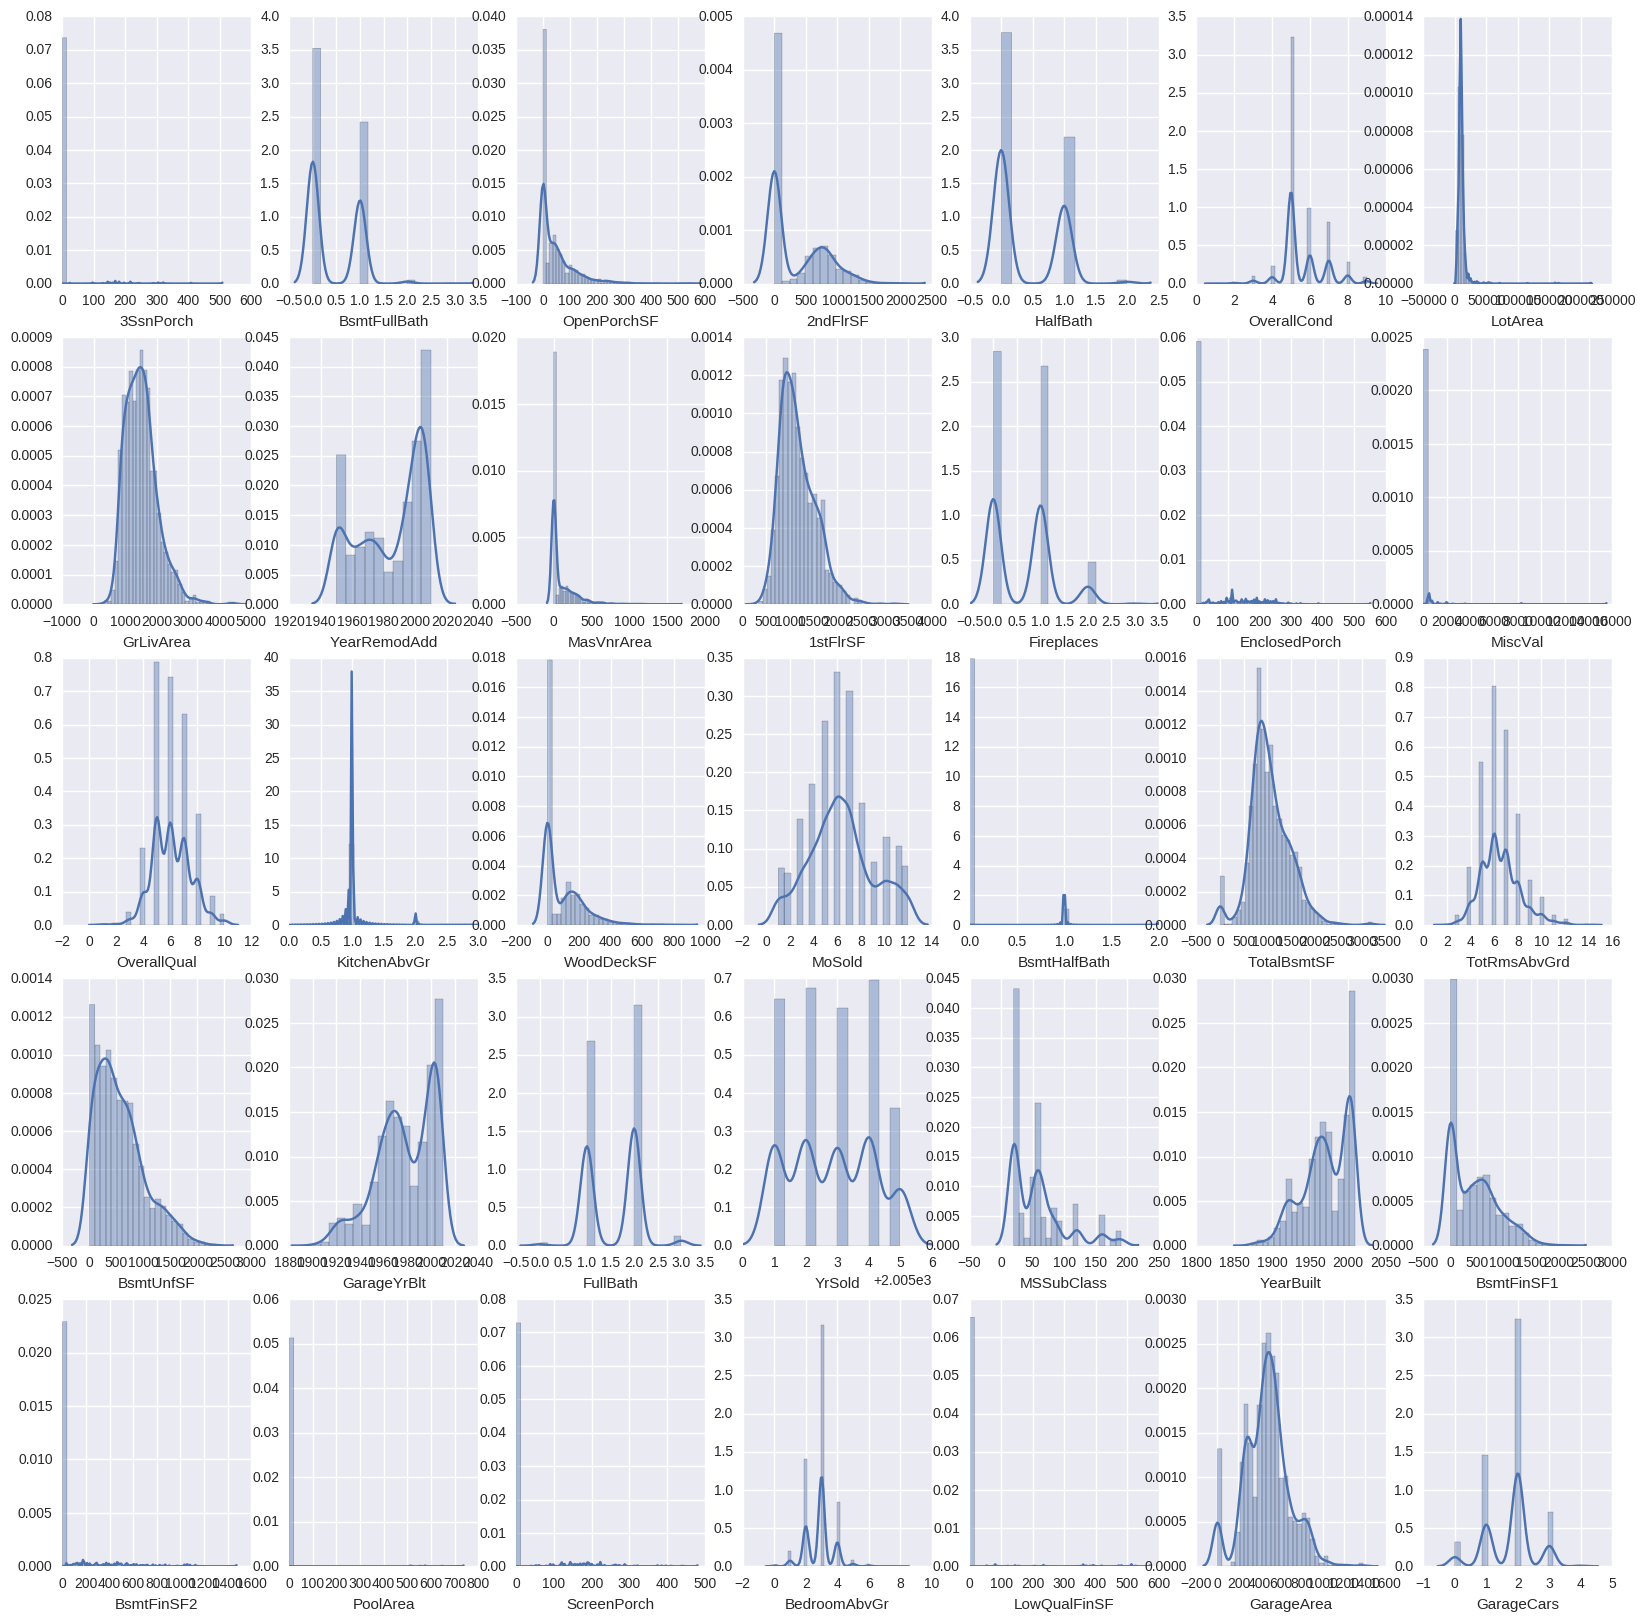

In [17]:
# Similarly, look at other numeric features
rcParams['figure.figsize'] = 20, 20
# take a look of each variable vs y
print "number of numeric columns: ", len(num_columns)
f, axes = plt.subplots(5,7)
n_iter = 0
for i in range(5):
    for j in range(7):
        sns.distplot(train_df[num_columns[n_iter]],ax=axes[i][j])
        n_iter += 1

### Skewness

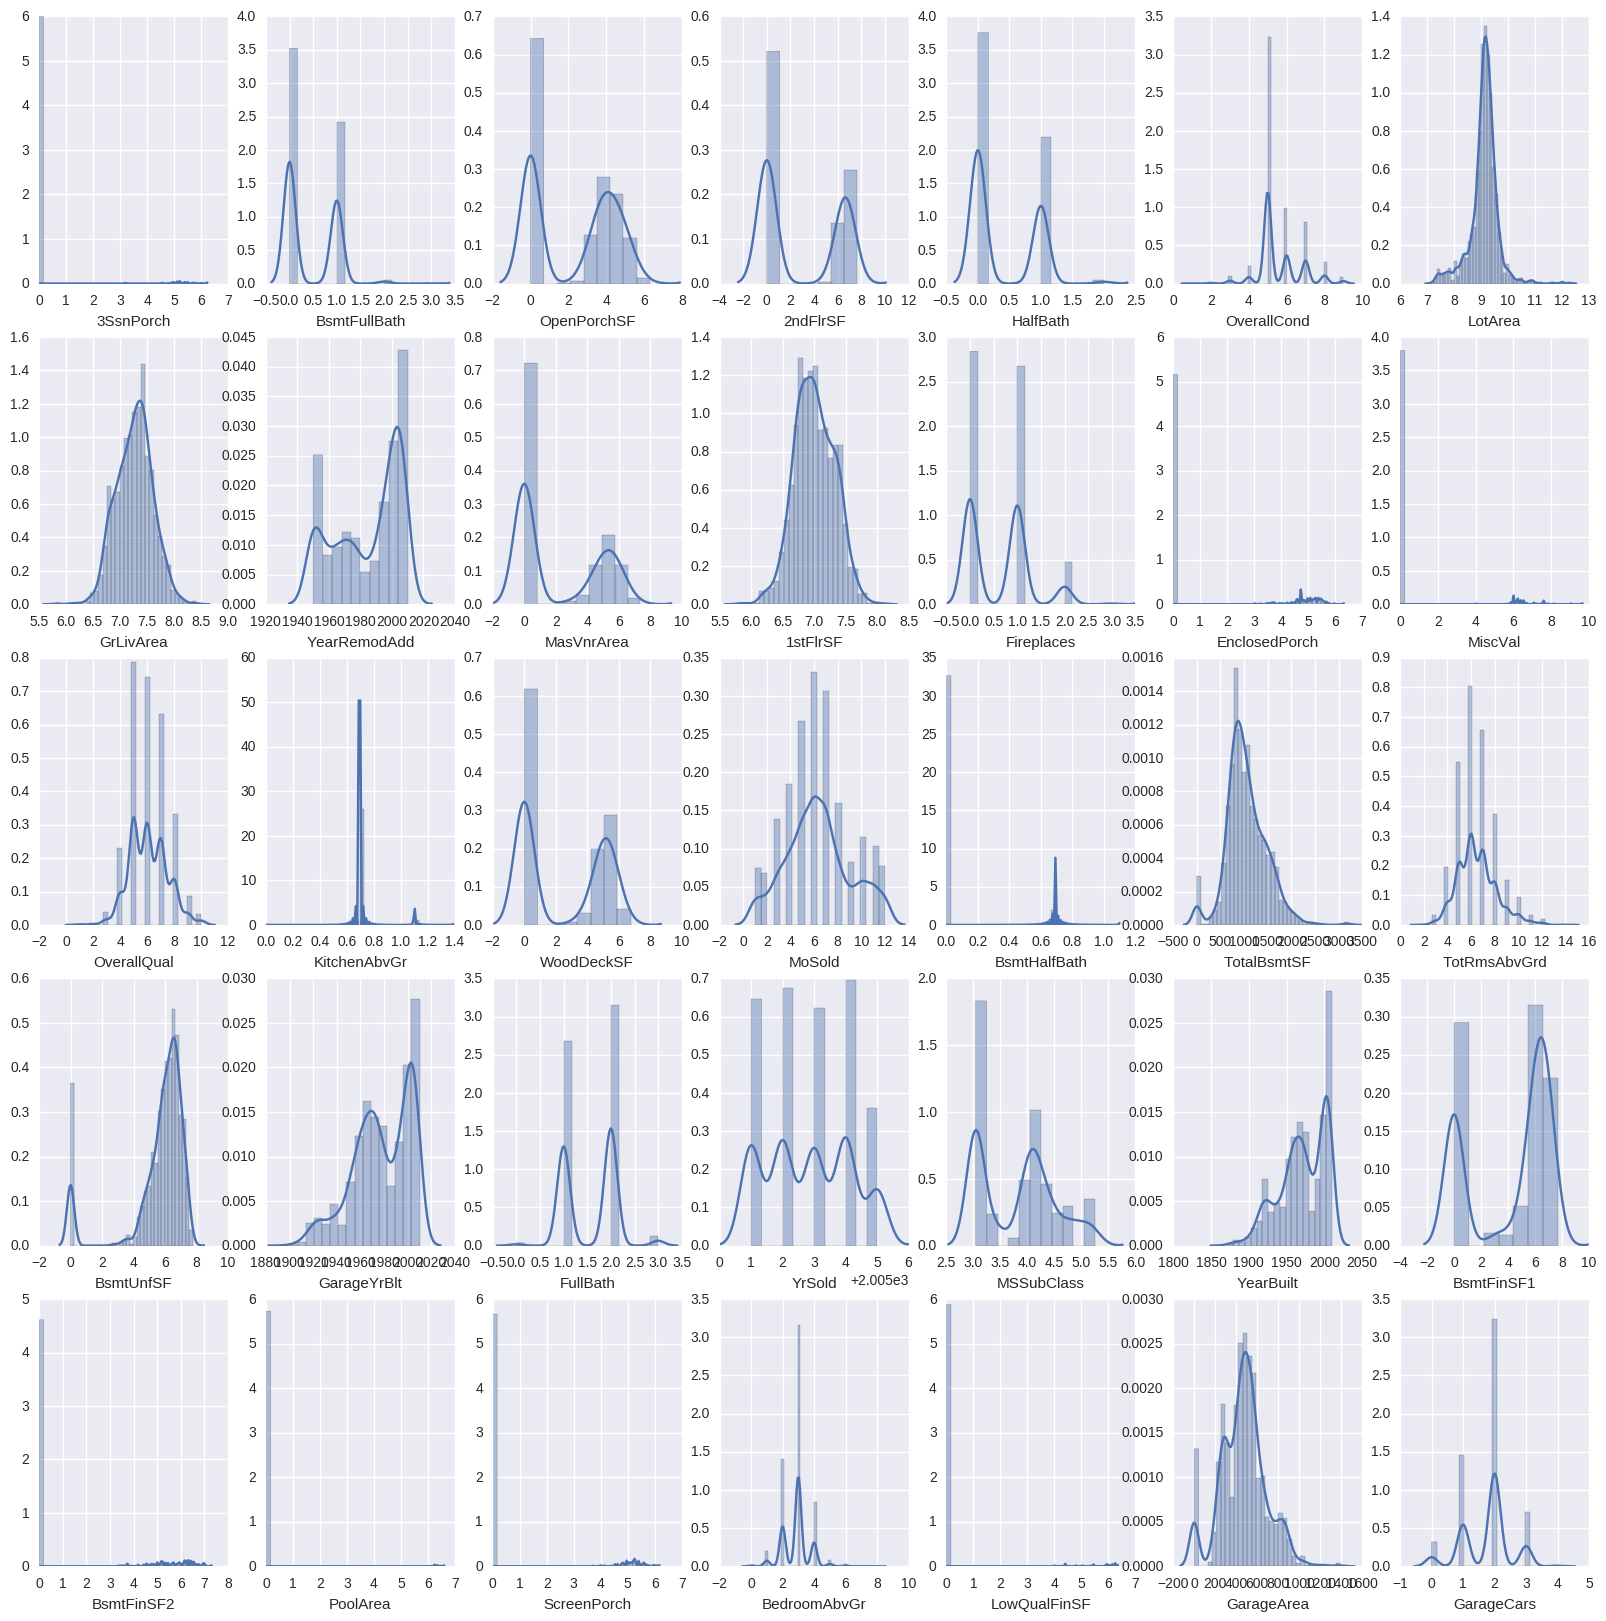

In [18]:
# compute skewness aloong column/feature
skewed_fts = train_df[num_columns].apply(lambda x: skew(x), axis=0) 
skewed_fts = skewed_fts[np.abs(skewed_fts) > 0.75]
skewed_fts = skewed_fts.index

train_df[skewed_fts] = np.log1p(train_df[skewed_fts])
test_df[skewed_fts] = np.log1p(test_df[skewed_fts])
# now take a look again
f, axes = plt.subplots(5,7)
n_iter = 0
for i in range(5):
    for j in range(7):
        sns.distplot(train_df[num_columns[n_iter]],ax=axes[i][j])
        n_iter += 1

In [20]:
# Standarization
# fisrt option: standarize non-categoorical values
# std_features = list(set(train_df.columns)-set(obj_columns))
# ss = StandardScaler(copy=True, with_mean=True, with_std=True)
# train_df[std_features] = ss.fit_transform(train_df[std_features])
# test_df[std_features] = ss.transform(test_df[std_features])

# second option: standarize all values
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
train_df[train_df.columns] = ss.fit_transform(train_df)
test_df[test_df.columns] = ss.transform(test_df)

In [21]:
# train_df[num_columns].describe()

In [22]:
# train_df[num_columns].head()

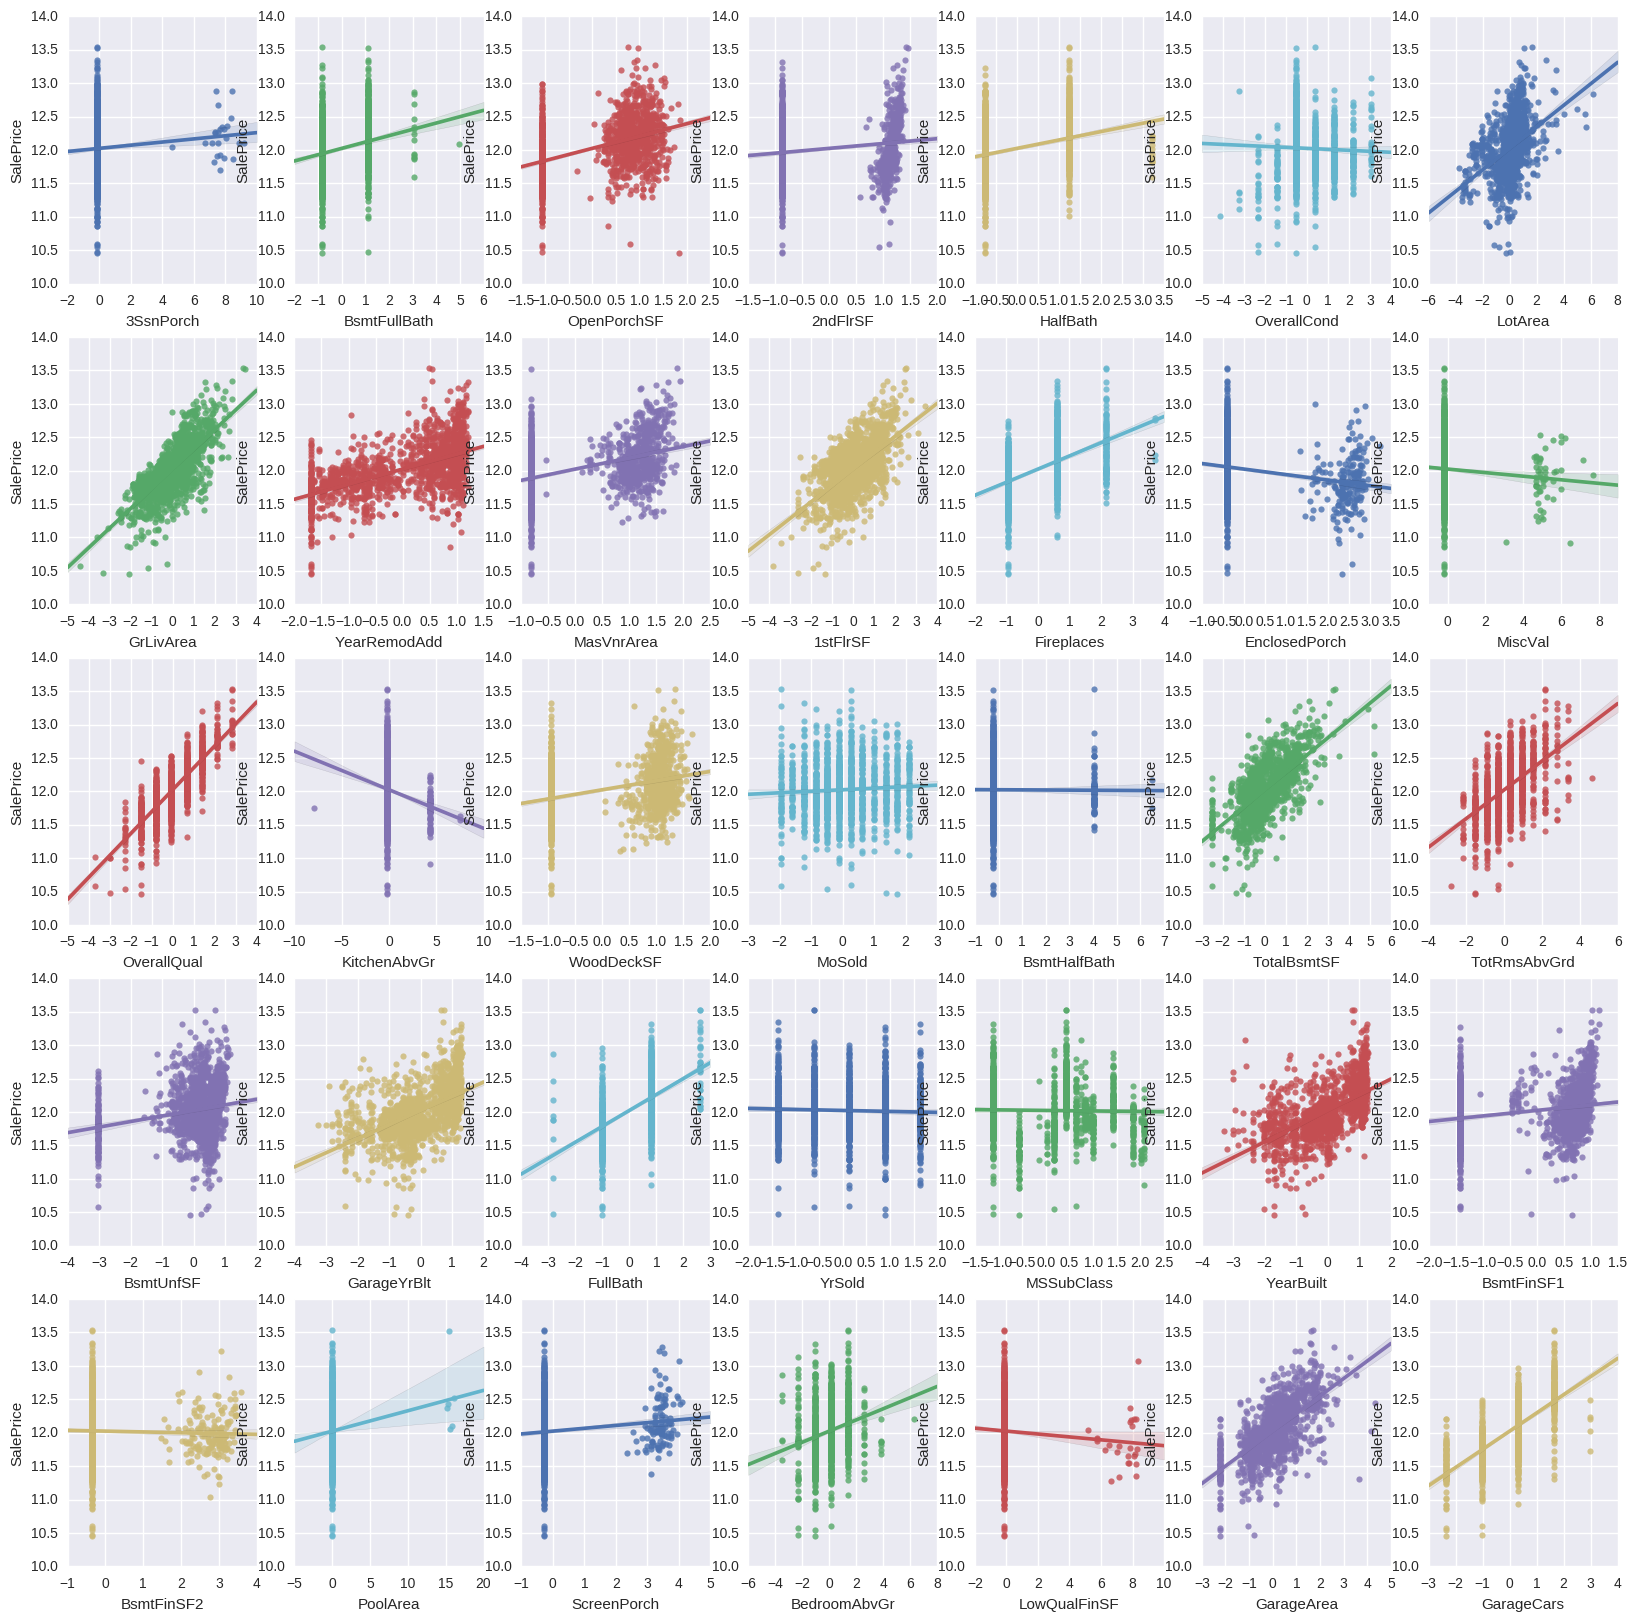

In [23]:
rcParams['figure.figsize'] = 20, 20
# take a look of each variable vs y
f, axes = plt.subplots(5,7)
n_iter = 0
for i in range(5):
    for j in range(7):
        sns.regplot(x=train_df[num_columns[n_iter]], y=train_y,ax=axes[i][j])
        n_iter += 1

In [27]:
# sns.regplot(x=train_df['GrLivArea'], y=train_y)

### multicollinearity

In [22]:
# look at correlations
correlations = train_df.corr()
cor_abs = np.abs(correlations)
cor_pair = cor_abs[(cor_abs>0.5) & (cor_abs != 1)].unstack().dropna().to_dict()
print "Total pair number:", len(correlations)*(len(correlations)-1)/2
cor_sort = sorted(cor_pair, key=cor_pair.get)[::-1]
cor_value = [cor_pair[k] for k in cor_sort]
cor_df = pd.DataFrame({'pair':cor_sort, 'cor': cor_value})
cor_df.drop_duplicates(subset='cor', inplace=True)
print "Correlated pairs(abs>0.5): ", cor_df.shape[0]
cor_df.head(10)

Total pair number: 2628
Correlated pairs(abs>0.5):  48


,cor,pair
0,0.887304,"(GarageArea, GarageCars)"
2,0.853926,"(Exterior2nd, Exterior1st)"
4,0.850960,"(BsmtFinSF2, BsmtFinType2)"
6,0.822983,"(TotRmsAbvGrd, GrLivArea)"
8,0.795111,"(YearBuilt, GarageYrBlt)"
10,0.783890,"(1stFlrSF, TotalBsmtSF)"
12,0.780625,"(BsmtFinSF1, BsmtFinType1)"
14,0.680390,"(TotRmsAbvGrd, BedroomAbvGr)"
16,0.652879,"(GrLivArea, FullBath)"
18,0.636755,"(ExterQual, KitchenQual)"


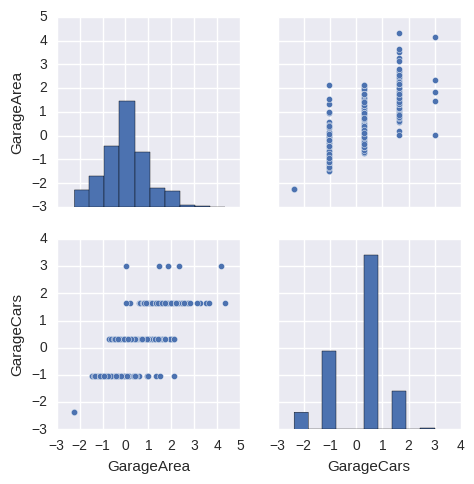

In [23]:
ax = sns.pairplot(train_df[['GarageArea', 'GarageCars']])

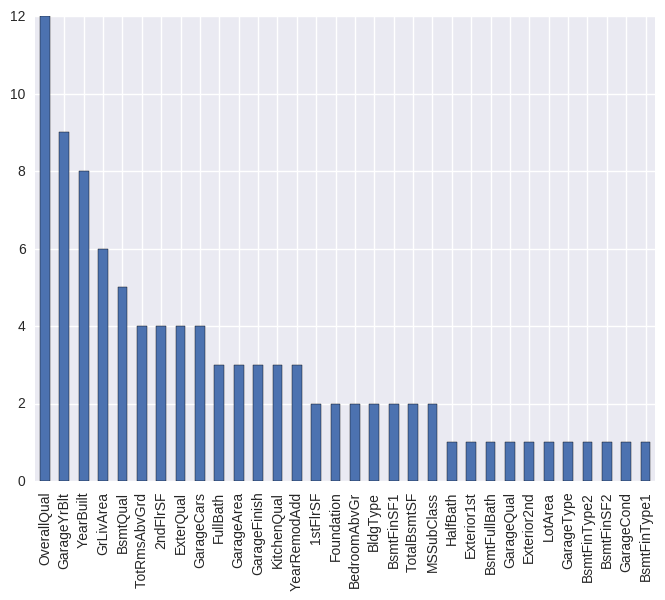

In [24]:
# from above we choose some features to discard
cor_freq = pd.DataFrame({'fts': [x for pair in cor_df['pair'].values for x in pair]})
cor_freq['fts'].value_counts().plot(kind='bar', figsize=(8,6))

In [25]:
# drop some of the features
freq_fts = list(cor_freq['fts'].value_counts()[:10].index)
top_cor = [pair for pair in cor_df['pair'][:10].values]
drop_fts = ['GarageCars', 'Exterior1st', 'BsmtFinType2', 'GarageYrBlt', 'LotFrontage', 'FullBath']

# comment out below if not dropping
# train_df.drop(drop_fts, axis=1, inplace=True)
# test_df.drop(drop_fts, axis=1, inplace=True)

### Try PCA

In [26]:
# due to multicollinearity, perform PCA on dataset and see if result improves
# n_features = train_df.shape[1]
# print "Total number of features before PCA: ", n_features

# pca = PCA(n_features)
# pca.fit_transform(train_df)

# explained = pca.explained_variance_ratio_
# n_use = 60
# print "Covers {} variance".format(sum(explained[:n_use]))

# pca = PCA(n_use)
# train_df = pca.fit_transform(train_df)
# test_df = pca.transform(test_df)

### train GB regressor

In [27]:
def find_params(train_X, train_Y, test_X, params_found=False, verbose=False):
    if not params_found:
        print "Finding params ..."
        t1 = time.time()
        param_grid = {'learning_rate':[0.1, 0.01, 0.001],
                      'max_depth': [3,4,6],
                      'min_samples_leaf': [3,5,9,17],
                      'max_features': [0.05, 0.1, 0.3, 0.5]}
        est = ensemble.GradientBoostingRegressor(loss='huber', n_estimators=5000)
        gs_cv = GridSearchCV(est, param_grid, cv=ShuffleSplit(n_splits=4, test_size=0.25, random_state=42),
                             n_jobs=4).fit(train_X, train_Y)
        t2 = time.time()

        best_est = gs_cv.best_estimator_
        
        print "Total time used: {0:.2f} min".format((t2-t1)/60.)
        print gs_cv.best_score_
        print gs_cv.best_params_
        return gs_cv.best_params_, best_est.feature_importances_
    else:
        print "Use previous found best params."
    
bg_param, bg_fts = find_params(train_df.values, train_y.values, test_df.values, params_found=False, verbose=True)
# find_params(train_df, train_y.values, test_df, params_found=True, verbose=True)

Finding params ...
Total time used: 15.41 min
0.912590728242
{'max_features': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3}


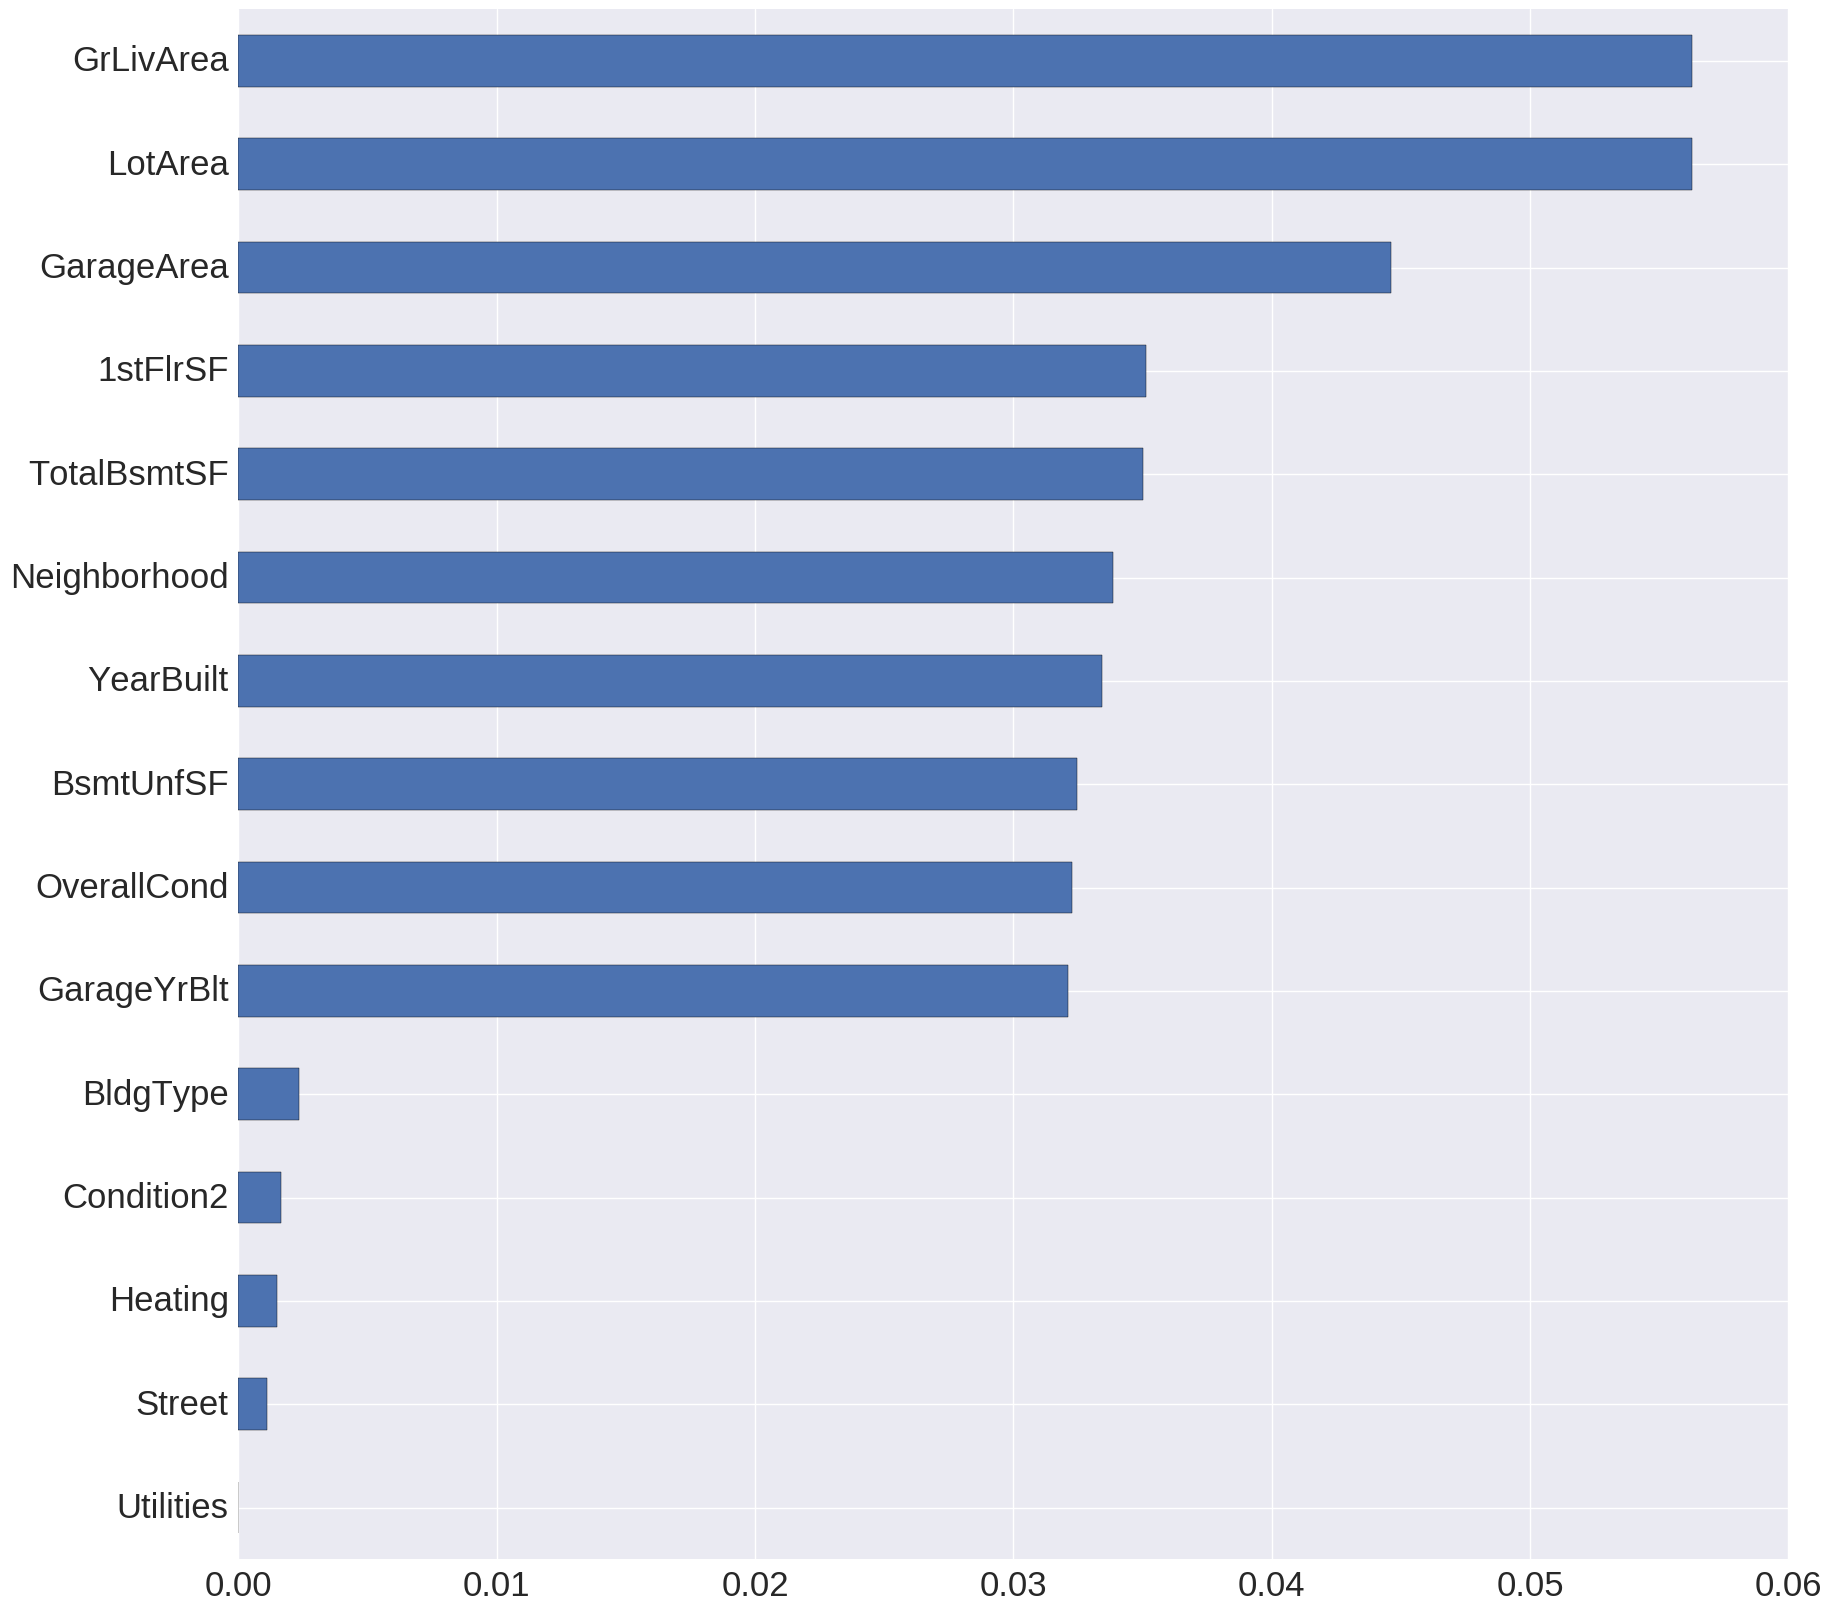

In [28]:
coef = pd.Series(bg_fts, index=train_df.columns)
imp_coef = pd.concat([coef.sort_values().head(5), coef.sort_values().tail(10)])
imp_coef.plot(kind='barh', fontsize=25)

In [29]:
# def train_predict(train_X, train_Y, test_X, ensemble_tol=None, verbose=False):
#     n_cv = 500
#     prediction = []
#     n_tol = 0
#     for n_i in range(n_cv):
#         if verbose:
#             print "[CV {}]".format(n_i)
#         x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=42+n_i)
#         bst = ensemble.GradientBoostingRegressor(n_estimators=8000, max_features=bg_param['max_features'], 
#                                                  loss='huber', 
#                                                  learning_rate=bg_param['learning_rate'], 
#                                                  max_depth=bg_param['max_depth'], 
#                                                  min_samples_leaf=bg_param['min_samples_leaf'],
#                                                  random_state=None)
#         bst.fit(x_train, y_train)
#         preds = bst.predict(x_val)
        
#         preds = np.expm1(preds)
#         y_val = np.expm1(y_val)
#         r2 = metrics.r2_score(y_val, preds)
#         rmsle = np.sqrt(sum((np.log(np.array(preds)+1)-np.log(np.array(y_val)+1))**2)/len(preds))
#         print "r2:", r2
#         print "RMSLE:", rmsle
        
#         prediction_i = bst.predict(test_X)
        
#         if ensemble_tol:
#             if rmsle <= ensemble_tol:
#                 prediction.append(prediction_i)
#                 n_tol += 1
#         else:
#             prediction.append(prediction_i)
#     print "Done training and predicting."
#     if ensemble_tol:
#         print "In total {} contributes to ensemble out of {}".format(n_tol, n_cv)
    
#     prediction = np.array(prediction)
#     ensemble_result = []
#     n, m = prediction.shape
#     p_std = np.std(prediction, axis=0) # along columns
#     p_mean = np.mean(prediction, axis=0)
#     for i in range(m):
#         p_i = prediction[:,i]
#         select_i = p_i[np.abs(p_i-p_mean[i]) < 1.*p_std[i]]
#         ensemble_result.append(np.mean(select_i))
#     # transform y back to normal scale
#     ensemble_result = np.expm1(ensemble_result)
#     result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble_result})
#     result_df.to_csv('./result/result_gb8k_final1.csv', index=False)
    
#     return prediction

# # e_tol = 0.13
# e_tol = None
# all_prediction = train_predict(train_df.values, train_y.values, test_df.values, ensemble_tol= e_tol, verbose=True)
# # train_predict(train_df, train_y, test_df, verbose=True)

In [30]:
# for i in all_prediction:
#     plt.plot(range(len(i)), i, 'o')

### Try lasso regression

In [31]:
def find_params(train_X, train_Y, test_X, params_found=False, rd = 42, verbose=False):
    if not params_found:
        print "Finding params ..."
        t1 = time.time()
        param_grid = {'alpha': 10**np.linspace(-6, 0, 100)}
        lasso = linear_model.Lasso(max_iter=50000)
        lasso_cv = GridSearchCV(lasso, param_grid, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=rd), 
                                n_jobs=4).fit(train_X, train_Y)
        t2 = time.time()

        cv_df = pd.DataFrame(lasso_cv.cv_results_)
        
        best_lasso = lasso_cv.best_estimator_
        print "Total time used: {0:.2f} min".format((t2-t1)/60.)
        print lasso_cv.best_score_
        print lasso_cv.best_params_
        
        return cv_df, lasso_cv.best_params_['alpha'], best_lasso.coef_
    else:
        print "Use previous found best params."
    
# find_params(train_df.values, train_y.values, test_df.values, params_found=True, verbose=True)
cv_df, best_alpha, coef = find_params(train_df.values, train_y.values, test_df.values, params_found=False, verbose=True)

Finding params ...
Total time used: 0.33 min
0.910742772222
{'alpha': 0.0016297508346206451}


In [32]:
# coef = pd.Series(coef, index=train_df.columns)
# imp_coef = pd.concat([coef.sort_values().head(5), coef.sort_values().tail(10)])
# imp_coef.plot(kind='barh', fontsize=25)

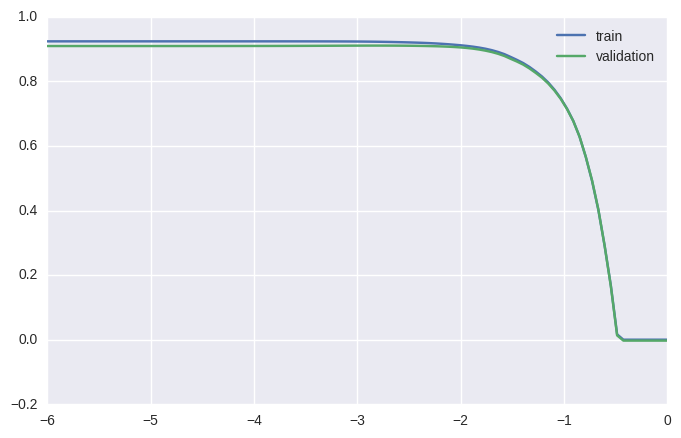

In [33]:
rcParams['figure.figsize'] = 8, 5
plt.plot(cv_df['param_alpha'].apply(lambda x: np.log10(x)), cv_df['mean_train_score'],
         cv_df['param_alpha'].apply(lambda x: np.log10(x)), cv_df['mean_test_score'])
plt.legend(('train', 'validation'), loc='best')

In [34]:
# def train_predict(train_X, train_Y, test_X, ensemble_tol=None, verbose=False):
#     n_cv = 100
#     prediction = []
#     n_tol = 0
#     for n_i in range(n_cv):
#         if verbose:
#             print "[CV {}]".format(n_i)
#         x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=42+n_i)

#         _, best_alpha = find_params(train_X, train_Y, test_X, params_found=False, rd=42+n_i, verbose=True)
# #         lm_i = linear_model.LinearRegression()
#         lm_i = linear_model.Lasso(max_iter=50000, alpha=best_alpha)
#         lm_i.fit(x_train, y_train)
#         preds = lm_i.predict(x_val)
        
#         preds = np.expm1(preds)
#         y_val = np.expm1(y_val)
        
#         r2 = metrics.r2_score(y_val, preds)
#         rmsle = np.sqrt(sum((np.log(np.array(preds)+1)-np.log(np.array(y_val)+1))**2)/len(preds))
#         print "r2:", r2
#         print "RMSLE:", rmsle
        
#         prediction_i = lm_i.predict(test_X)
        
#         if ensemble_tol:
#             if rmsle <= ensemble_tol:
#                 prediction.append(prediction_i)
#                 n_tol += 1
#         else:
#             prediction.append(prediction_i)
#     print "Done training and predicting."
#     if ensemble_tol:
#         print "In total {} contributes to ensemble out of {}".format(n_tol, n_cv)
    
#     prediction = np.array(prediction)
#     ensemble_result = []
#     n, m = prediction.shape
#     p_std = np.std(prediction, axis=0) # along columns
#     p_mean = np.mean(prediction, axis=0)
#     for i in range(m):
#         p_i = prediction[:,i]
#         select_i = p_i[np.abs(p_i-p_mean[i]) < 1.*p_std[i]]
#         ensemble_result.append(np.mean(select_i))
#     # transform y back to normal scale
#     ensemble_result = np.expm1(ensemble_result)
#     result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble_result})
#     result_df.to_csv('./result/result_lasso_final1.csv', index=False)
    
#     return prediction

# e_tol = 0.13
# # e_tol = None
# all_prediction = train_predict(train_df.values, train_y.values, test_df.values, ensemble_tol= e_tol, verbose=True)
# # train_predict(train_df, train_y, test_df, verbose=True)

In [35]:
# for i in all_prediction:
#     plt.plot(range(len(i)), i, 'o')